In [8]:
import random
import sys
sys.path.append("../../../")
from simulation_classes.eta.car import Cars
from simulation_classes.eta.CWPTable import CWPTable
from simulation_classes.eta.SimulationClass import ETASimulation
sys.path.append("../")
from utils import find_delta_v_list, find_delta_x_list
from tqdm.notebook import tqdm

### このシミュレーションコードでは以下のパラメータを動かす
- 大域密度
- 車の台数
- TTC

In [41]:
""" 初期設定（独立変数群）"""
CAR_NUM = 15 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
ORIFITH_LENGTH = 5 # 整流区間長さ. 最後のCWPのindexで指定。
MEAN_SPEED = 20 # 秒速[m/s]として定義
SCALE_FACTOR = 20 #シミュレーション上で距離を変換するための係数
TIME_STEP = 1
V_MAX = 40

# ETAに関する設定
GLOBAL_TIME_WINDOW = 100  # Strategic Phaseでの時間幅
BATCH_NUM = 1
WINDOW_SIZE = (GLOBAL_TIME_WINDOW / BATCH_NUM)
DESIRED_TTC = 5 # 目標とする車間時間 [s]
DESIRED_SPEED = 21 # 目標とする出口速度 [m/s]

# 車のパラメータ
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 2 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

helly_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":False
  }

def crt_params_list():
    time_window_list = [50, 100, 200]
    car_num_list = [3,5,8,10,12,15,18, 20,25,30, 40]
    TTC_list = [1,3,5]
    return [{"window": w, "car_num": car_num, "TTC":ttc} for w in time_window_list for car_num in car_num_list for ttc in TTC_list]

In [52]:
"""
続いてシミュレーションの用意
パラメータの組み合わせはparamListという変数にまとめて格納されているものとし、paramListを一つ一つ取り出してシミュレーションする
"""
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
iterations = 50 # 1回のparamListについて何回シミュレーションするか

simulation_list = []
paramList = crt_params_list()
simulation_length = iterations * len(paramList)
last_simulation_list = []
print(simulation_length)

for paramSet in tqdm(paramList):
    for i in range(iterations):
        # ここからシミュレーション開始
        arrival_times = sorted([random.uniform(0, paramSet["window"]) for _ in range(paramSet["car_num"])])
        CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED, \
              helly_params=helly_params, group_id=group_id, order_in_group=index)
              for index, time in enumerate(arrival_times)]
        global_params = {"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":paramSet["TTC"], \
                         "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX, "CAR_NUM":paramSet["car_num"]}

        
        cwp_table_controlled = CWPTable(waypoints = WAYPOINTS, algorithm = "CONTROLLED", \
                     global_params = global_params)
        cwp_table_simpler = CWPTable(waypoints = WAYPOINTS, algorithm = "KISS", \
                     global_params = global_params)

        simulation_params = {"TOTAL_TIME": paramSet["window"]+50, "TIME_STEP":TIME_STEP}

        # 続いてシミュレーションオブジェクトを初期化
        eta_simulation_controlled = ETASimulation(CARS=CARS, CWPTable=cwp_table_controlled, simulation_params=simulation_params)
        eta_simulation_simpler = ETASimulation(CARS=CARS, CWPTable=cwp_table_simpler, simulation_params=simulation_params)
        last_simulation_list = [{"simulation_obj": eta_simulation_controlled, "algorithm":"CONTROLLED", **paramSet}]

        # 実行
        eta_simulation_simpler.conduct_simulation()
        eta_simulation_controlled.conduct_simulation()

        simulation_list.append({"simulation_obj": eta_simulation_simpler, "algorithm":"KISS", **paramSet})
        simulation_list.append({"simulation_obj": eta_simulation_controlled, "algorithm":"CONTROLLED", **paramSet})

       
print("DONE.")

4950


  0%|          | 0/99 [00:00<?, ?it/s]

DONE.


9900


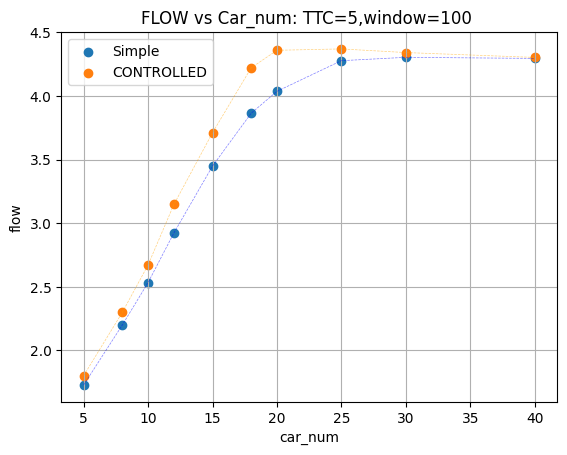

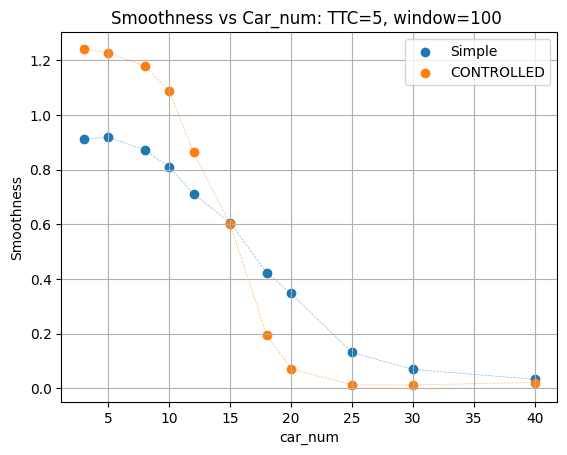

In [65]:
# 解析していくンゴ
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


filter_ttc = 5
filter_window = 100

print(len(simulation_list))
modified_data_list = [{**item, "flow": item["simulation_obj"].calc_flow(), "rectify": item["simulation_obj"].calc_rectification()} for item in simulation_list]
df_list = [{k: v for k, v in item.items() if k != 'simulation_obj'} for item in modified_data_list]
df = pd.DataFrame(df_list)
df_window_100 = df[df['window'] == filter_window]
grouped = df_window_100.groupby(['algorithm', 'car_num', 'TTC']).mean().reset_index()
# print(grouped)
colors = ["blue", "orange"]


# プロットの作成
for idx, algorithm in enumerate(['KISS', 'CONTROLLED']):
    subset = grouped[(grouped['algorithm'] == algorithm) & (grouped["TTC"] == filter_ttc)& (grouped["car_num"] >= 4)]
    plt.scatter(subset['car_num'], subset['flow'], label="Simple" if algorithm=="KISS" else algorithm)
    plt.plot(subset['car_num'], subset['flow'],color=colors[idx], alpha=0.5, linestyle="--", linewidth=0.5)

plt.xlabel('car_num')
plt.ylabel('flow')
plt.title("FLOW vs Car_num: TTC={0},window={1} ".format(filter_ttc, filter_window ))
plt.grid()
plt.legend()
plt.show()

for algorithm in ['KISS', 'CONTROLLED']:
    subset = grouped[(grouped['algorithm'] == algorithm) & (grouped["TTC"] == filter_ttc)]
    plt.scatter(subset['car_num'], subset['rectify'], label="Simple" if algorithm=="KISS" else algorithm)
    plt.plot(subset['car_num'], subset['rectify'],  alpha=0.5, linestyle="--", linewidth=0.5)


plt.xlabel('car_num')
plt.ylabel('Smoothness')
plt.title("Smoothness vs Car_num: TTC={0}, window={1} ".format(filter_ttc, filter_window ))
plt.grid()

plt.legend()
plt.show()

990
{'simulation_obj': <simulation_classes.eta.SimulationClass.ETASimulation object at 0xffff75166210>, 'algorithm': 'CONTROLLED', 'window': 50, 'car_num': 3, 'TTC': 1}


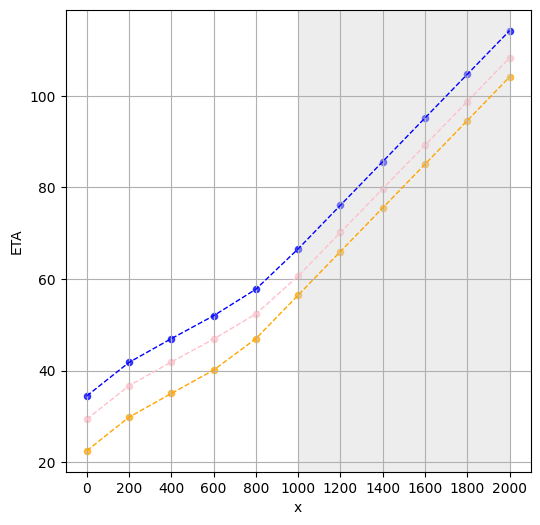

In [48]:
sample_simulation_obj = simulation_list[1]
print(len(simulation_list))
print(simulation_list[1])
simulation = sample_simulation_obj["simulation_obj"]
simulation.cwp_table.plot()

In [4]:
# シミュレーションにミスがあった時のデバッグ用のセル

In [5]:
simObj = last_simulation_list[0]
print(simObj)
cars = simObj["simulation_obj"].CARS
arrival_times = [car.arrival_time for car in cars]
print(arrival_times)

simObj["simulation_obj"].conduct_simulation()


{'simulation_obj': <simulation_classes.eta.SimulationClass.ETASimulation object at 0xffff75052540>, 'algorithm': 'CONTROLLED', 'window': 200, 'car_num': 40, 'TTC': 5}
[9.440259705901987, 9.626210883045117, 20.378963029104003, 20.673560499055267, 21.49094430739522, 30.170912626290814, 35.60774035324299, 44.855797727174675, 49.728201638947226, 58.127965203562496, 63.99886749544916, 65.01811608720185, 69.39362159152856, 69.49328946066365, 77.27241070267664, 79.17629193420406, 86.45744139653048, 89.01401217900329, 90.32019713394772, 108.64318062865156, 109.56047994938724, 110.67841562756237, 114.7566024175184, 121.24113402137996, 128.61868478900374, 137.89289549454585, 139.72136840764057, 141.22768910082135, 143.13652782507202, 145.25006829468288, 147.1705364575433, 157.44284458747174, 166.02640116046265, 170.29237281179144, 172.38547381230828, 173.8652973886391, 176.1816323320389, 185.29051510403536, 188.91806749058696, 197.00626094134492]


192
{'simulation_obj': <simulation_classes.eta.SimulationClass.ETASimulation object at 0xffff7539e000>, 'algorithm': 'KISS', 'window': 50, 'car_num': 10, 'TTC': 5}


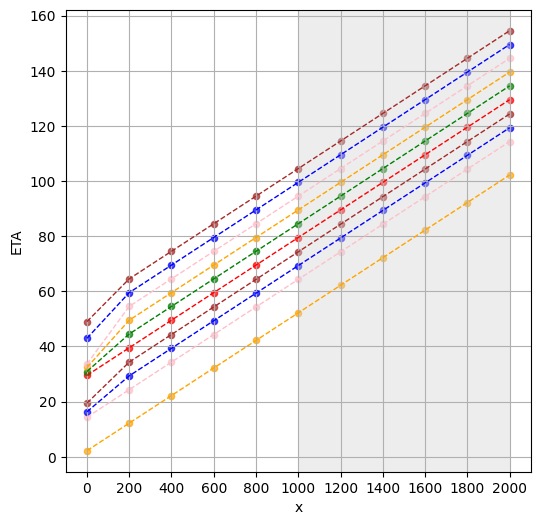

In [6]:
sample_simulation_obj = simulation_list[20]
print(len(simulation_list))
print(simulation_list[20])
simulation = sample_simulation_obj["simulation_obj"]
simulation.cwp_table.plot()
